In [11]:
#!pip install pandas
#!pip install matplotlib
#!pip install scikit-image

# Importamos librerías
import zipfile
import pandas as pd
import numpy as np
from io import BytesIO
from matplotlib import pyplot as plt
import math
from scipy.signal import find_peaks
from skimage.util import view_as_windows

import json
from collections import defaultdict

In [12]:
def zip_to_dataframe(file_path, file_name, names):
    file_path_zip = f'{file_path}/{file_name}.zip'
    file_name_txt = f'{file_name}.txt'
    with zipfile.ZipFile(file_path_zip) as thezip:
        with thezip.open(file_name_txt, mode='r') as thefile:
            data = thefile.read()
            return pd.read_csv(BytesIO(data), sep = '\t', index_col = False, names = names, skiprows=range(3), decimal = ',')
        

def plot_df(df, n, name):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set_size_inches(16, 8)
    fig.suptitle(name)

    ax1.plot(df.LP.iloc[:n],lw=0.4)
    ax1.set_title("LP")
    ax1.grid(True)

    ax2.plot(df.VD.iloc[:n],'tab:orange',lw=0.4)
    ax2.set_title("VD")
    ax2.grid(True)

    fig.tight_layout()

def my_ceil(a, precision=0):
    return np.round(a + 0.5 * 10**(-precision), precision)

def get_threshold(df):
    return my_ceil(df.mean() + 4.5*df.std(),2)

def plot_spikes(df,threshold, n, name):
    peaks_clp, _ = find_peaks(df.LP[:n], threshold[0])
    peaks_cvd, _ = find_peaks(df.VD[:n], threshold[1])

    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set_size_inches(16, 8)
    fig.suptitle(name)

    ax1.plot(df.LP[:n],lw=0.3)
    ax1.plot(peaks_clp, df.LP[:n][peaks_clp], "x")
    ax1.set_title("LP")
    ax1.grid(True)

    ax2.plot(df.VD[:n],'tab:orange',lw=0.3)
    ax2.plot(peaks_cvd, df.VD[:n][peaks_cvd], "x")
    ax2.set_title("VD")
    ax2.grid(True)

    fig.tight_layout()

def plot_distances(clp_distance,cvd_distance,bins):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(16, 8)
    fig.suptitle('Distancias')

    ax1.hist(clp_distance,bins=bins)
    ax1.set_xlim((0, 400))
    ax1.set_title("LP")


    ax2.hist(cvd_distance,bins=bins)
    ax2.set_title("VD")
    ax2.set_xlim((0, 400))

    fig.tight_layout()

def discretize(df,clp_spikes,cvd_spikes):
    df['LP_events'] = 0
    df.LP_events[clp_spikes] = 1
    df['VD_events'] = 0
    df.VD_events[cvd_spikes] = 1
    return df

def get_errors_rate(series, bin_sizes):
    errors_rate = []
    for bin_size in bin_sizes:
        bins_spikes = view_as_windows(series,window_shape=bin_size, step=bin_size).sum(axis=1)
        errors_rate.append((bins_spikes>1).sum()/len(series))
    return np.array(errors_rate)

def plot_error_rate(clp_errors,cvd_errors,bin_sizes,name):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(16, 8)
    fig.suptitle('Tasa error por ventana {}'.format(name))

    ax1.plot(bin_sizes,clp_errors)
    ax1.set_title("LP")

    ax2.plot(bin_sizes,cvd_errors)
    ax2.set_title("VD")

    fig.tight_layout()

def to_words(series, nbits, nsteps):
    if nbits == 1:
        return np.array(list(map(str,series)))
    else:
        series_bin = view_as_windows(np.array(series),window_shape=nbits, step=nsteps)
        return np.array([''.join(map(str,bins)) for bins in series_bin])

def prob(x): # x : np of str (words)
    keys, counts = np.unique(x, return_counts=True)
    return dict(zip(keys,counts/len(x)))

def joint_prob(x, y):  # x,y : np of str (words)
    xy = list(map('|'.join,zip(x, y)))
    keys, counts = np.unique(xy, return_counts=True)
    return dict(zip(keys,counts/len(x)))

def entropy(x): # x : dict of probabilities
    return - np.sum([w * np.log2(w) for w in x.values()])
    
def MI(x, y): # x,y : np of str (words)
    px, py, pxy = prob(x),prob(y),joint_prob(x,y)
    ex, ey = entropy(px), entropy(py)
    mi=0
    for k in pxy:
        kx, ky = k.split('|')
        mi += pxy[k] * np.log2(pxy[k]/(px[kx] * py[ky]))
    return mi, ex, ey

In [13]:
file_path = '/home/maria/Escritorio/TI/DatosSinapsisArtificial'

# Análisis GABA (TrozoG)

In [14]:
filename = 'TrozoG'
name = 'GABA'
names = ['LP','VD']
trozoG = zip_to_dataframe(file_path, filename, names)

/home/maria/main/main/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


In [15]:
print('Number of channels = ', len(trozoG.columns)) # 2
print('Number of samples per channel = ', len(trozoG)) # 19847700
trozoG.head()

Number of channels =  2
Number of samples per channel =  16384000


,LP,VD
0,-0.006104,0.064697
1,-0.004272,0.075989
2,-0.003357,0.087280
3,-0.005188,0.092468
4,-0.007324,0.093384


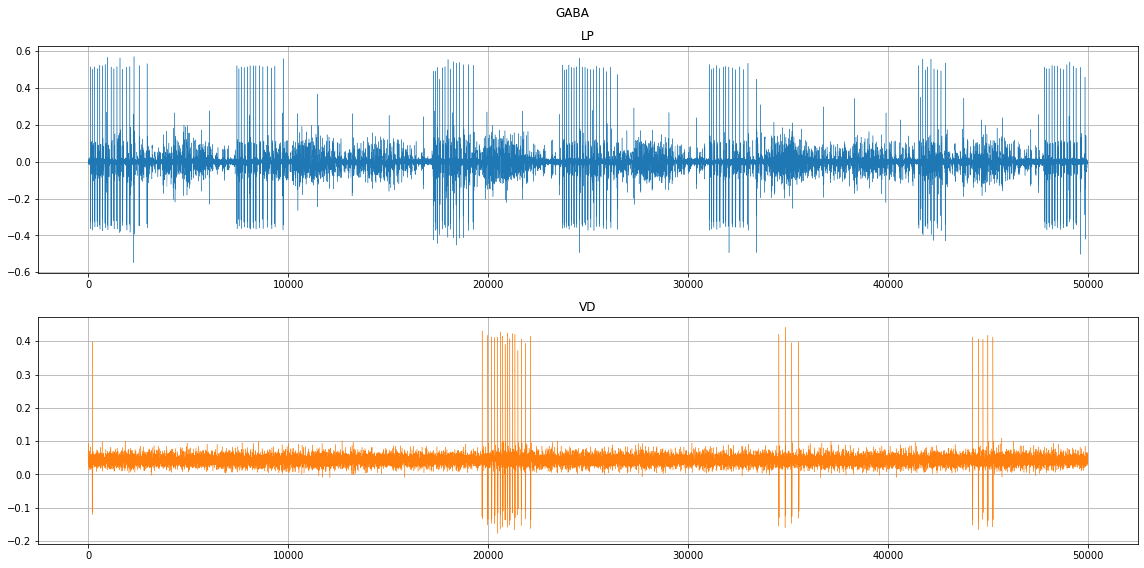

In [16]:
n = 50000
plot_df(trozoG,n, name)

### Detección de spikes

In [17]:
threshold = get_threshold(trozoG)
threshold

LP    0.37
VD    0.20
dtype: float64

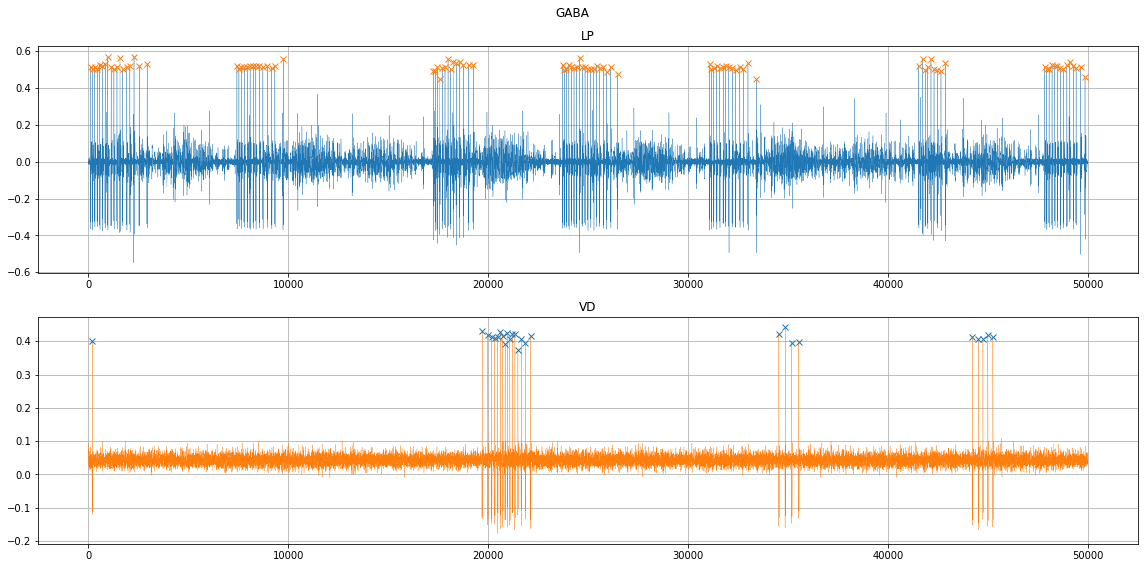

In [18]:
plot_spikes(trozoG,threshold, n, name)

In [19]:
clp_spikes,_ = find_peaks(trozoG.LP, threshold[0])
cvd_spikes,_ = find_peaks(trozoG.VD, threshold[1])

In [20]:
print('Total spikes LP = ', len(clp_spikes))
print('Total spikes VD = ', len(cvd_spikes))

Total spikes LP =  26633
Total spikes VD =  15662


### Distancia entre spikes

In [21]:
clp_distances = np.diff(clp_spikes)

print('Min = ', np.amin(clp_distances))
print('Max = ',np.amax(clp_distances))
print('Mean = ',np.mean(clp_distances))
print('Medium = ',np.median(clp_distances))
print('Q1 = ',np.quantile(clp_distances, 0.00025))

Min =  4
Max =  14121
Mean =  614.9039876839892
Medium =  155.0
Q1 =  24.65775


In [22]:
cvd_distances = np.diff(cvd_spikes)

print('Min = ', np.amin(cvd_distances))
print('Max = ',np.amax(cvd_distances))
print('Mean = ',np.mean(cvd_distances))
print('Medium = ',np.median(cvd_distances))
print('Q1 = ',np.quantile(cvd_distances, 0.00025))

Min =  2
Max =  21409
Mean =  1045.8287465679075
Medium =  191.0
Q1 =  62.915


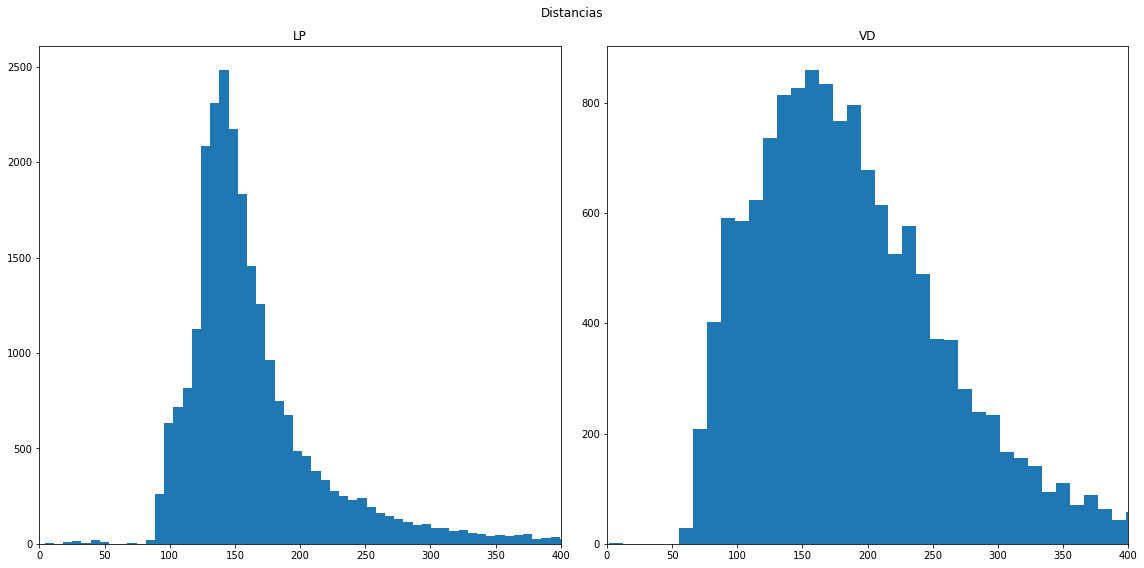

In [23]:
plot_distances(clp_distances,cvd_distances,2000)

In [24]:
trozoG = discretize(trozoG,clp_spikes,cvd_spikes)

/tmp/ipykernel_30965/2555316580.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.LP_events[clp_spikes] = 1
/tmp/ipykernel_30965/2555316580.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.VD_events[cvd_spikes] = 1


In [25]:
bin_sizes = range(1,151)
clp_errors = get_errors_rate(np.array(trozoG.LP_events),bin_sizes)
cvd_errors = get_errors_rate(np.array(trozoG.VD_events),bin_sizes)

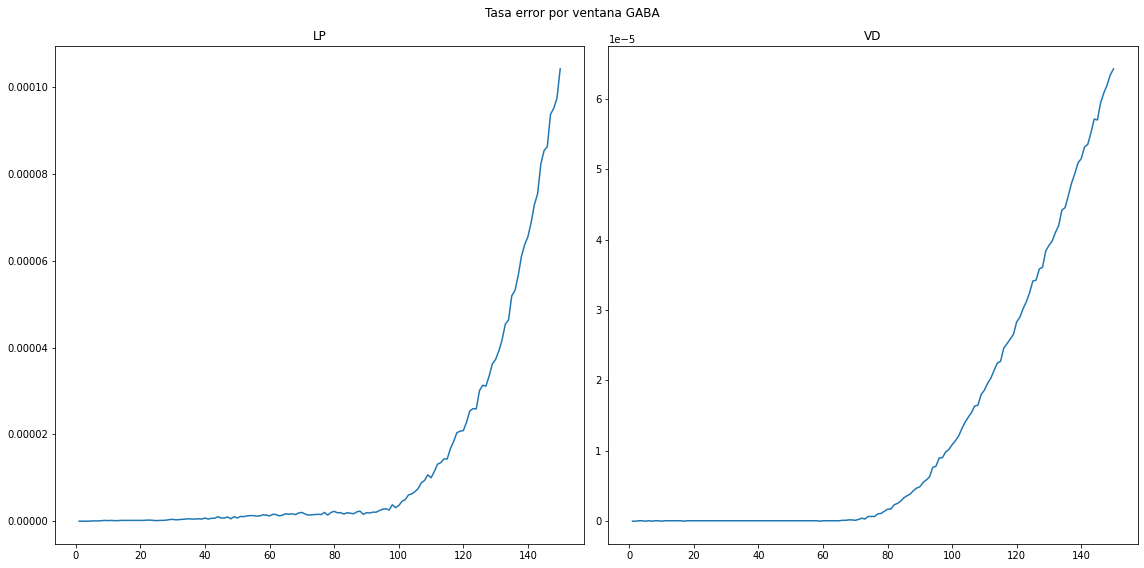

In [26]:
plot_error_rate(clp_errors,cvd_errors,bin_sizes,name)

### Ventanas deslizantes

#### Palabra = 1 bit

In [17]:
nbits = 1
clp_words_1 = to_words(trozoG.LP_events, nbits, 1)
cvd_words_1 = to_words(trozoG.VD_events, nbits, 1)

In [19]:
prob_clp_1,prob_cvd_1 = prob(clp_words_1),prob(cvd_words_1)
print("Probabilidades Control LP con 1 bit: \n{0}".format(json.dumps(prob_clp_1,sort_keys=True, indent=2)))
print("\nProbabilidades Control VD con 1 bit: \n{0}".format(json.dumps(prob_cvd_1,sort_keys=True, indent=2)))
joint_prob_1 = joint_prob(clp_words_1,cvd_words_1)
print("\nProbabilidades Conjuntas Control LP y VD con 1 bit: \n{0}".format(json.dumps(joint_prob_1,sort_keys=True, indent=2)))
mi_1, e_clp_1, e_cvd_1 = MI(clp_words_1,cvd_words_1)
print("\nEntropía Control LP con 1 bit: {0}".format(e_clp_1))
print("\nEntropía Control VD con 1 bit: {0}".format(e_cvd_1))
print("\nInformación Mutua Control LP y VD con 1 bit: {0}".format(mi_1))

Probabilidades Control LP con 1 bit: 
{
  "0": 0.9983744506835938,
  "1": 0.00162554931640625
}

Probabilidades Control VD con 1 bit: 
{
  "0": 0.9990440673828125,
  "1": 0.0009559326171875
}

Probabilidades Conjuntas Control LP y VD con 1 bit: 
{
  "0|0": 0.9974185791015625,
  "0|1": 0.00095587158203125,
  "1|0": 0.00162548828125,
  "1|1": 6.103515625e-08
}

Entropía Control LP con 1 bit: 0.017403746703910126

Entropía Control VD con 1 bit: 0.010967232059934903

Información Mutua Control LP y VD con 1 bit: 1.871404374609573e-06


In [ ]:
n = 4
mi, elp, evd = [], [], []
for i in range(1,n+1):
    lp_words = to_words(trozoG.LP_events, i,1)
    vd_words = to_words(trozoG.VD_events, i,1)
    m_i, e_lp, e_vd = MI(lp_words,vd_words)
    mi.append(m_i)
    elp.append(e_lp)
    evd.append(e_vd)
mi = np.array(mi)
elp = np.array(elp)
evd = np.array(evd)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 8)
fig.suptitle(f'{name} information')

ax1.plot(range(1,n+1),mi,lw=0.9)
ax1.set_title("MI")

ax2.plot(range(1,n+1),elp,lw=0.9,label='LP Entropy')
ax2.plot(range(1,n+1),evd,'tab:orange',label='VD Entropy',lw=0.9)
ax2.set_title("H")
ax2.legend()

fig.tight_layout()

In [ ]:
ti_lp_vd = mi/e_lp
ti_vd_lp = mi/e_vd

In [ ]:
# transformacion de informacion
plt.plot(range(1,9),ti_lp_vd, label = 'LP-->VD')
plt.plot(range(1,9),ti_vd_lp,label = 'VD-->LP')
plt.title('Information transmission')
plt.legend()
plt.show()